In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import contextily

import torch
import torch.nn as nn
import torch.nn.functional as F

c:\Repositories\gnn-traffic\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Plots

In [2]:
from torch_geometric_temporal.dataset import METRLADatasetLoader
loader = METRLADatasetLoader('data')
dataset = loader.get_dataset(num_timesteps_in=12, num_timesteps_out=12)

In [3]:
graph = nx.Graph()
for edge, weight in zip(dataset.edge_index.T, dataset.edge_weight):
    graph.add_edge(*edge, weight=weight)
graph.remove_edges_from(nx.selfloop_edges(graph))

In [4]:
locations = pd.read_csv('https://raw.githubusercontent.com/tijsmaas/TrafficPrediction/master/data/metr-la/graph_sensor_locations.csv')
locations = locations[['longitude', 'latitude']].to_numpy()

In [5]:
speed = np.load('data/node_values.npy')
speed = speed[:,:,0] # timestamp, sensor, feature[speed, timeofday]

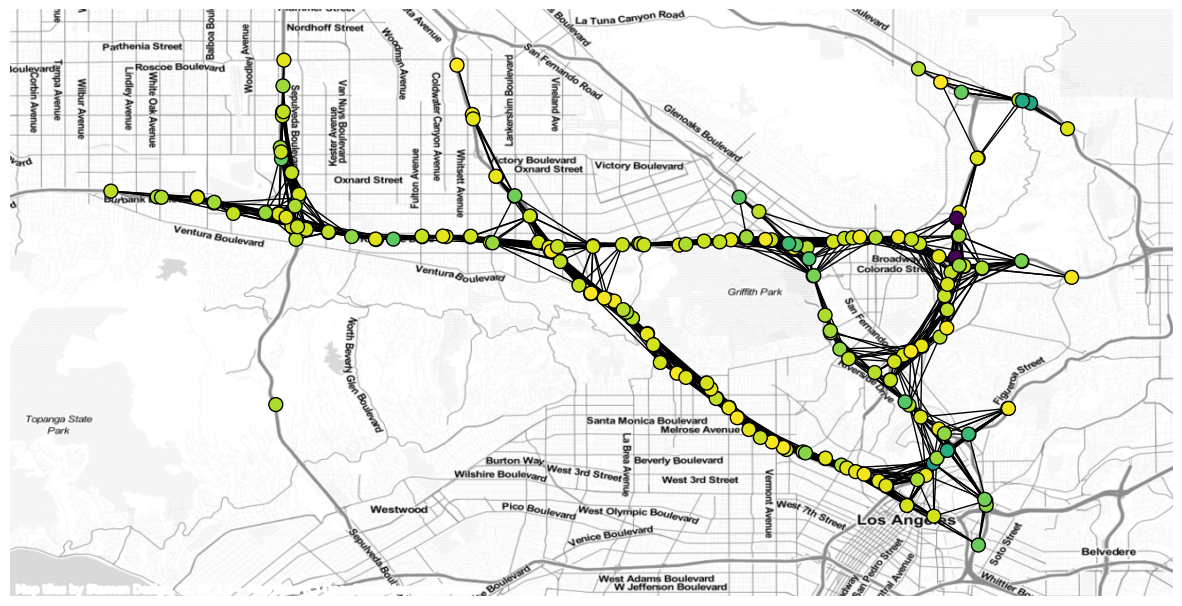

In [8]:
positions = dict(zip(graph.nodes, locations[graph.nodes]))
node_colors = speed[0,:][graph.nodes]
# edge_colors = [graph[x][y]['weight'] for x,y in graph.edges]

fig, ax = plt.subplots(figsize=(15,15))
nx.draw(graph, positions, node_color=node_colors, edgecolors='black', ax=ax, node_size=100)
contextily.add_basemap(ax=ax, crs=4326, source=contextily.providers.Stamen.TonerLite)

In [35]:
dataset.edge_index.T[dataset.edge_index.T[:,0] == 6]

array([[  6,   6],
       [  6,  16],
       [  6,  91],
       [  6,  93],
       [  6, 124],
       [  6, 136],
       [  6, 174]], dtype=int64)

In [44]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

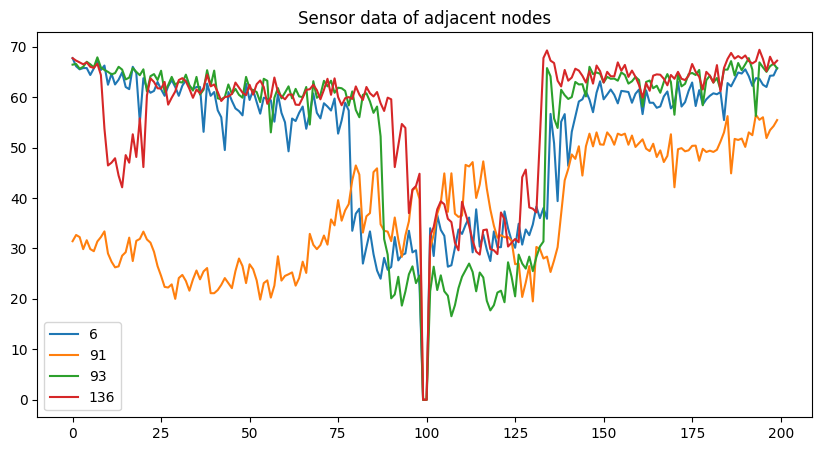

In [65]:
with plt.style.context('default'):
    plt.figure(figsize=(10,5))
    plt.plot(speed[-200:,6], label='6')
    plt.plot(speed[-200:,91], label='91')
    plt.plot(speed[-200:,93], label='93')
    plt.plot(speed[-200:,136], label='136')
    plt.legend()
    plt.title('Sensor data of adjacent nodes')

In [59]:
plt.rcParams['image.cmap'] = 'viridis'

In [145]:
adjacency = np.load('data/adj_mat.npy')

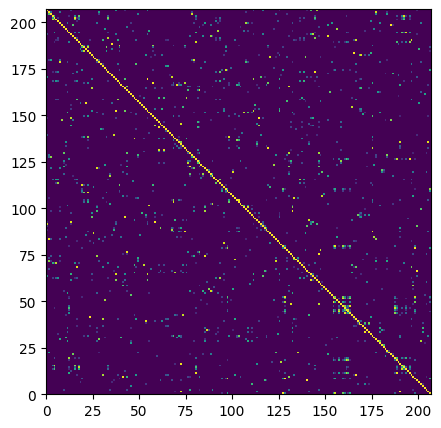

In [148]:
fig, ax = plt.subplots(figsize=(5,5))
ax.pcolormesh(adjacency[::-1,:])
ax.set_aspect('equal')

# Model training

In [2]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from src import METRLADataModule, TemporalGNN
from src.printer import PrintMetricsCallback
from src.utils import read_logs

In [3]:
import warnings
warnings.filterwarnings('ignore', '.*does not have many workers.*')

In [4]:
data = METRLADataModule(root_dir='data', train_steps=12, predict_steps=12, num_workers=0, batch_size=16)
model = TemporalGNN(model_name='A3TGCN', out_channels=64)
# model = TemporalGNN(model_name='ASTGCN', nb_block=2, nb_chev_filter=64, nb_time_filter=64)

In [5]:
best_checkpointer = ModelCheckpoint(
    save_top_k=1, save_last=True, monitor='val_loss', mode='max', filename='best')
csv_logger = CSVLogger('')
printer = PrintMetricsCallback(
    metrics=['val_loss', 'train_loss'])

trainer = pl.Trainer(
    log_every_n_steps=1,
    logger=csv_logger,
    callbacks=[best_checkpointer, printer],
    max_epochs=10,
    accelerator='auto',
    devices=1)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [6]:
trainer.fit(model, data)


  | Name      | Type    | Params
--------------------------------------
0 | tgnn      | A3TGCN  | 25.4 K
1 | linear    | Linear  | 780   
2 | act       | ReLU    | 0     
3 | criterion | MSELoss | 0     
--------------------------------------
26.1 K    Trainable params
0         Non-trainable params
26.1 K    Total params
0.105     Total estimated model params size (MB)


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  2.20it/s]

c:\Repositories\gnn-traffic\.venv\lib\site-packages\pytorch_lightning\utilities\data.py:85: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1656. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  2.62it/s]epoch: -1
val_loss: 4.2680559158325195
────────────────────────────────────────────────────────────────────────────────
Epoch 0: 100%|██████████| 750/750 [05:35<00:00,  2.23it/s, loss=0.925, v_num=11]epoch: 0
val_loss: 0.6673015356063843
train_loss: 1.0758209228515625
────────────────────────────────────────────────────────────────────────────────
Epoch 1: 100%|██████████| 750/750 [05:23<00:00,  2.32it/s, loss=0.63, v_num=11] epoch: 1
val_loss: 0.6309011578559875
train_loss: 0.41623297333717346
────────────────────────────────────────────────────────────────────────────────
Epoch 2: 100%|██████████| 750/750 [05:40<00:00,  2.20it/s, loss=0.555, v_num=11]epoch: 2
val_loss: 0.6186881065368652
train_loss: 0.3567594885826111
────────────────────────────────────────────────────────────────────────────────
Epoch 3: 100%|██████████| 750/750 [07:37<00:00,  1.64it/s, loss=0.718, v_num=11]epoch: 3
val_loss: 0.6033023595809

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 750/750 [06:54<00:00,  1.81it/s, loss=0.494, v_num=11]


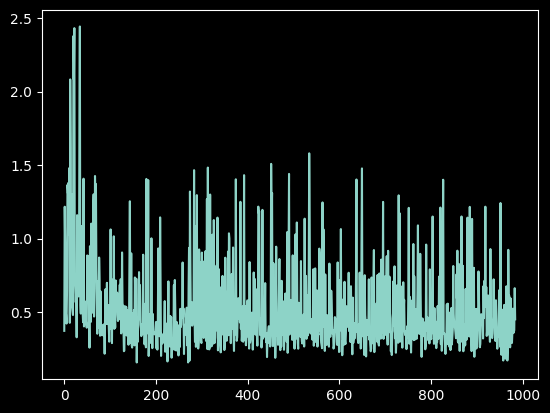

In [8]:
logs = read_logs('lightning_logs/version_9/metrics.csv')
plt.plot(logs['train_loss_step'])